# AlexNet for Image classification.

A simple implementation of [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) for playing around with.
Training it on CIFAR-10 as it's a standard dataset that is largely solved.

This (obivously) is no great acheivement in and of itself, but is intended as a spring board, especially for me to understand the computer science version of a convolution.

In [1]:
import torch
import torchvision
import torchvision.transforms as tfms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda


We set the batch size, this is proportional to the memory available on your device.
The author used the value below, but feel free to experiment with it!

Use a value somewhere between 2 and 32 according to [this paper](https://arxiv.org/abs/1804.07612).

In [2]:
bs = 32

## CIFAR-10

CIFAR-10 is a labelled subset of the [80 million tiny images dataset](https://en.wikipedia.org/wiki/80_Million_Tiny_Images), with 6000 32x32 colour images in 10 classes, with 6000 images per class.
There are 50,000 training images and 10,000 test images.

The dataset can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

In [3]:
mean = (0.5, 0.5, 0.5)  # (r, g, b)
std =  (0.5, 0.5, 0.5)  # (r, g, b)

transforms = tfms.Compose([
    tfms.ToTensor(),
    tfms.Normalize(mean, std)
])

In [4]:
dataset = torchvision.datasets.CIFAR10('./data', train=True, download=True , transform=transforms)
testset = torchvision.datasets.CIFAR10('./data', train=False, download=True , transform=transforms)

trainset, valset = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.9), int(len(dataset) * 0.1)])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
valloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Dataset Exploration

We need to have a look at and truly understand the data to be able to classify it

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img.numpy() / 2 + 0.5  # Undo normalisation

    # Matplotlib expects H * W * C, PyTorch is C * H * W
    # So transpose and swizzle
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

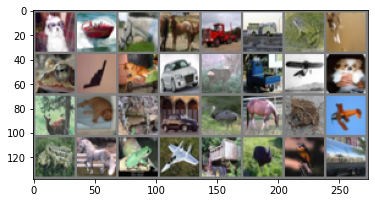

dog, ship, horse, horse, truck, truck, frog, dog, frog, plane, dog, car, deer, truck, plane, dog, deer, dog, frog, car, bird, horse, frog, plane, frog, horse, frog, plane, truck, bird, bird, truck


In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(", ".join(classes[labels[i]] for i in range(len(labels))))

## Model

### Convolutional Neural Networks (CNNs)

The convolution of two functions $f$ and $g$ is defined as:

$$
(f * g)(t) = \int_{-\infty}^{\infty} f(\tau) g(t - \tau) \text{d} \tau
$$

This doesn't explain a whole lot,

PyTorch (for the sake of fewer operations) decided to implement this as a different

$$
(f \otimes g)(t) = \int_{-\infty}^{\infty} f(\tau) g(t + \tau) \text{d} \tau
$$

This is associative, distributive, but isn't commutative! 

Under the usual well-behaved conditions, a convolution is a multilplication in Fourier space, i.e. 

$$
f * g = \mathcal{F}^{-1} \left\{
    \mathcal{F}\left( f \right) \cdot \mathcal{F}\left(g \right)
\right\},\\

f \otimes g = \mathcal{F}^{-1} \left\{
    \overline{ \mathcal{F}\left( f \right) } \cdot \mathcal{F}\left(g \right)
\right\}.
$$

This is ideal if you are wanting to calculate a bigger convolution, i.e. the kernel size is on the order of the signal.

### AlexNet

Our model is a typical [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) and is taken from the paper [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).

It looks like this:
![]()

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(torch.nn.Module):
    def __init__(self, D_in=32, D_out=10):
        """
        D_in:
            Width of Image to apply network to
        D_out:
            Number of classes to output
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3,   96,  5, padding=2)
        self.conv2 = nn.Conv2d(96,  256, 3, padding=1)
        self.conv3 = nn.Conv2d(256, 384, 2)
        self.conv4 = nn.Conv2d(384, 384, 2)
        self.conv5 = nn.Conv2d(384, 256, 2)

        # TODO: Experiment with cool pooling types
        self.pool = nn.MaxPool2d(2, 2)
        # self.pool = nn.AvgPool2d(2, 2)
        # self.pool = nn.AdaptiveMaxPool2d(2, 2)
        # self.pool = nn.AdaptiveAvgPool2d(2, 2)

        self.act = nn.Hardswish()
        # self.act = nn.ReLU()

        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, D_out)

    def forward(self, x):
        # Top 5 Conv layers
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = self.act(self.conv3(x))
        x = self.act(self.conv4(x))
        x = self.pool(self.act(self.conv5(x)))

        # Flatten
        x = torch.flatten(x, start_dim=1)

        # FC endpoint
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
model = AlexNet().to(device)

## Optimizer

Define a loss function and optimizer

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

### Fit 1cycle

In [38]:
num_epochs = 20

In [55]:
# Train first time
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1.e-3, steps_per_epoch=len(trainloader), epochs=num_epochs)

## Training

In [56]:
for epoch in range(num_epochs):

    running_loss = 0.

    for i, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass: Compute predicted y by passing x to the model
        outputs = model(inputs)

        # Compute and print loss
        loss = loss_fn(outputs, targets)

        # Perform a backward pass, and update the weights.
        loss.backward()
        optimizer.step()
        # scheduler.step()

        # Print statistics
        running_loss += loss.item()
        print_every = 500
        if i % print_every == print_every - 1:
            print(f"Epoch {epoch + 1}{i + 1:6}, train loss: {running_loss / (print_every * bs)}")  # loss since previous print out
            running_loss = 0.
    
    # At the end of the epoch, show the validation loss
    with torch.no_grad():
        validation_loss = 0.
        for i, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            validation_loss += loss_fn(outputs, targets).item()
        print(f"Epoch {epoch + 1}, validation loss: {validation_loss / (bs * len(valloader))}")
print("Finished Training")

Epoch 1   500, train loss: 0.01543320462014526
Epoch 1  1000, train loss: 0.015975268447771668
Epoch 1, validation loss: 0.013943695946442335
Epoch 2   500, train loss: 0.014130528374575079
Epoch 2  1000, train loss: 0.01470148277375847
Epoch 2, validation loss: 0.012561372302071468
Epoch 3   500, train loss: 0.012724471407942474
Epoch 3  1000, train loss: 0.013338309349026531
Epoch 3, validation loss: 0.011316176947383653
Epoch 4   500, train loss: 0.011435724735725671
Epoch 4  1000, train loss: 0.012090109917335213
Epoch 4, validation loss: 0.01038296807652661
Epoch 5   500, train loss: 0.010421604564879089
Epoch 5  1000, train loss: 0.011155321531929076
Epoch 5, validation loss: 0.008694781711975056
Epoch 6   500, train loss: 0.008849718915298581
Epoch 6  1000, train loss: 0.009992988653946667
Epoch 6, validation loss: 0.00837840101888169
Epoch 7   500, train loss: 0.007980504986131563
Epoch 7  1000, train loss: 0.008963534496491775
Epoch 7, validation loss: 0.006749085044586275
Epo

In [57]:
path = "./alexnet_cifar10-one-cycle-swish-fine-tune.pth"
torch.save(model.state_dict(), path)

## Evaluation

In [58]:
model.eval()

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 384, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (act): Hardswish()
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

### Confusion Matrix

This is a great little idea that visually represents how consfused the model is.
This shows visually, what the model predicted for a given number of inputs with its top one.

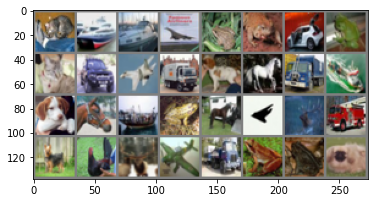

Ground truth: cat, ship, ship, plane, frog, frog, car, frog, cat, car, plane, truck, dog, horse, truck, ship, dog, horse, ship, frog, horse, plane, deer, truck, dog, bird, deer, plane, truck, frog, frog, dog
Model: cat, car, car, plane, frog, frog, car, bird, cat, truck, plane, truck, dog, horse, truck, deer, dog, horse, ship, frog, dog, plane, plane, truck, deer, bird, deer, frog, truck, frog, frog, dog


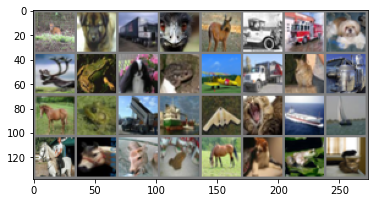

Ground truth: deer, dog, truck, bird, deer, car, truck, dog, deer, frog, dog, frog, plane, truck, cat, truck, horse, frog, truck, ship, plane, cat, ship, ship, horse, horse, deer, frog, horse, cat, frog, cat
Model: deer, cat, truck, ship, horse, car, truck, dog, deer, frog, dog, frog, truck, truck, bird, horse, horse, frog, truck, ship, frog, cat, ship, ship, horse, dog, dog, deer, horse, dog, frog, cat


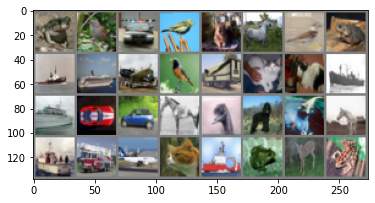

Ground truth: frog, bird, car, bird, cat, horse, bird, frog, ship, ship, plane, bird, truck, cat, cat, ship, ship, car, car, horse, bird, dog, bird, horse, ship, truck, plane, cat, ship, frog, deer, frog
Model: frog, bird, bird, bird, horse, horse, ship, cat, ship, ship, plane, deer, cat, cat, bird, ship, ship, car, car, horse, bird, horse, deer, truck, ship, truck, plane, frog, ship, frog, deer, frog


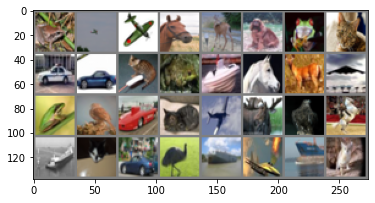

Ground truth: frog, plane, plane, horse, deer, dog, frog, cat, car, car, cat, frog, ship, horse, deer, plane, frog, bird, car, cat, plane, deer, bird, horse, ship, cat, car, bird, ship, plane, ship, cat
Model: frog, plane, plane, horse, deer, dog, frog, cat, car, car, cat, frog, cat, cat, deer, plane, frog, bird, car, deer, plane, deer, cat, dog, ship, deer, bird, bird, ship, truck, plane, cat


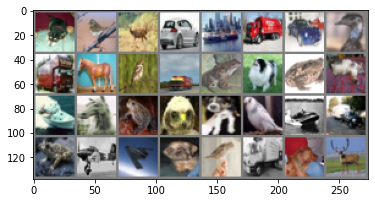

Ground truth: dog, bird, deer, car, ship, truck, car, bird, truck, horse, bird, truck, frog, dog, frog, cat, ship, horse, frog, bird, dog, bird, ship, truck, frog, plane, plane, dog, bird, truck, dog, deer
Model: cat, bird, deer, car, truck, truck, car, bird, truck, horse, bird, ship, cat, dog, cat, cat, ship, cat, frog, cat, dog, cat, ship, truck, frog, plane, plane, dog, bird, truck, cat, deer


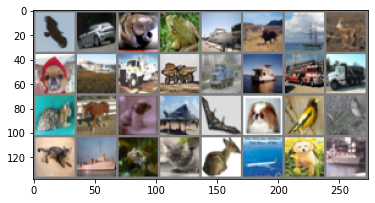

Ground truth: bird, car, frog, frog, ship, deer, ship, deer, dog, plane, truck, truck, truck, ship, truck, truck, cat, horse, dog, plane, plane, dog, bird, bird, cat, ship, frog, cat, deer, plane, dog, ship
Model: plane, car, dog, bird, bird, deer, ship, deer, dog, plane, truck, plane, plane, ship, truck, truck, cat, deer, dog, plane, plane, dog, bird, bird, dog, ship, frog, cat, cat, ship, deer, ship


In [59]:
for batch_idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.to(device), targets.to(device)

    imshow(torchvision.utils.make_grid(inputs).cpu())

    outputs = model(inputs)
    top_one = torch.argmax(outputs, dim=-1)

    print("Ground truth:", ", ".join(classes[targets[i]] for i in range(len(targets))))
    print("Model:", ", ".join(classes[top_one[i]] for i in range(len(top_one))))

    if batch_idx >= 5:
        break

In [60]:
cm = torch.zeros(len(classes), len(classes))

for i, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.to(device), targets.to(device)
    
    targets_pred = model(inputs)
    top_one = torch.argmax(targets_pred, dim=-1) # Take the estimate of the top-one

    for j in range(len(targets_pred)):
        cm[top_one[j], targets[j]] += 1.

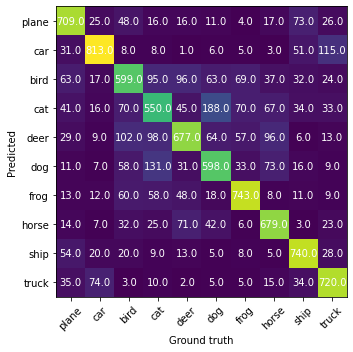

In [61]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, cmap="viridis")
    plt.xlabel("Ground truth")
    plt.ylabel("Predicted")
    plt.xticks(range(len(classes)), classes, rotation=45)
    plt.yticks(range(len(classes)), classes)

    # Add text
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.gca().text(j, i, f"{cm[i, j]:.1f}", ha="center", va="center", color="w")

    plt.tight_layout()
    plt.show()
plot_confusion_matrix(cm, classes)

In [62]:
accuracy = torch.sum(torch.diag(cm)) / torch.sum(torch.sum(cm))
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 68.28%


In [63]:
test_loss = 0.
for i, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    test_loss += loss_fn(outputs, targets).item()
print(f"Test loss: {test_loss / (bs * len(testloader))}")

Test loss: 0.04211830806891663
